# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (8, 6)

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
geo_comment = pd.read_excel('geo_comment.xlsx')


In [4]:
geo = pd.read_excel('geo.xlsx')

In [5]:
geo_comment.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [6]:
geo.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [7]:
geo_comment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70382 entries, 0 to 70381
Data columns (total 5 columns):
x                70382 non-null float64
y                70382 non-null float64
comment_class    70382 non-null int64
multiplier       70382 non-null int64
comment          70382 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 3.2+ MB


In [8]:
coords = geo[['x', 'y']]

In [9]:
coords.head()

,x,y
0,37.612416,55.777454
1,37.612416,55.777454
2,37.603298,55.742108
3,37.558526,55.728758
4,37.566431,55.731794


построим карту голосовавших

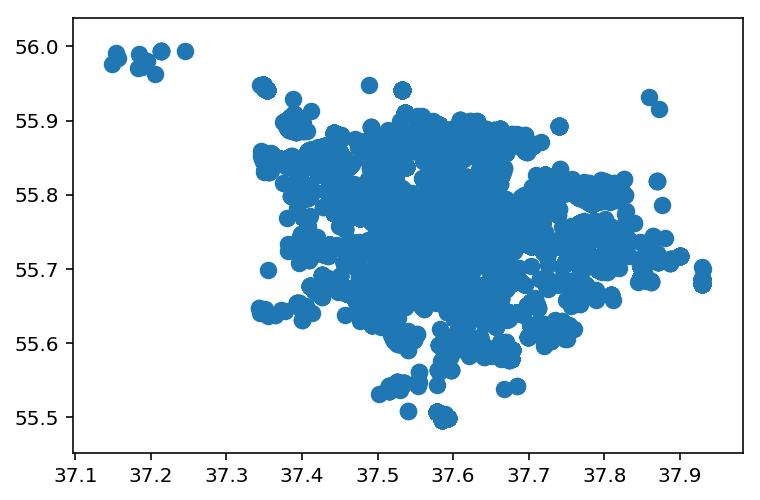

In [10]:
plt.scatter(coords.x, coords.y, s=60)

In [11]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

Разделим голосовавших предварительно на 10 кластеров

In [12]:
clusters = KMeans(n_clusters=10).fit_predict(coords)

In [13]:
clusters

array([1, 1, 1, ..., 3, 4, 3])

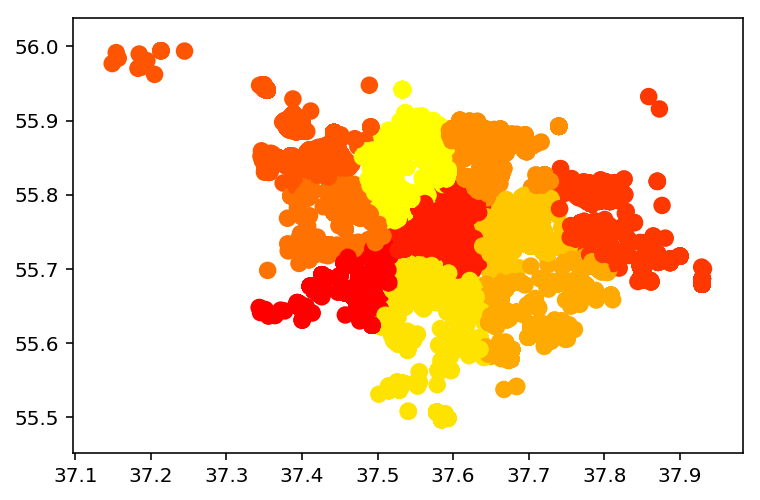

In [14]:
plt.scatter(coords.x, coords.y, c=clusters, cmap='autumn', s=60)

Подберем оптимальное число кластеров

In [15]:
k_inertia = []
ks = range(1,21)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(coords, )
    k_inertia.append(clf_kmeans.inertia_)

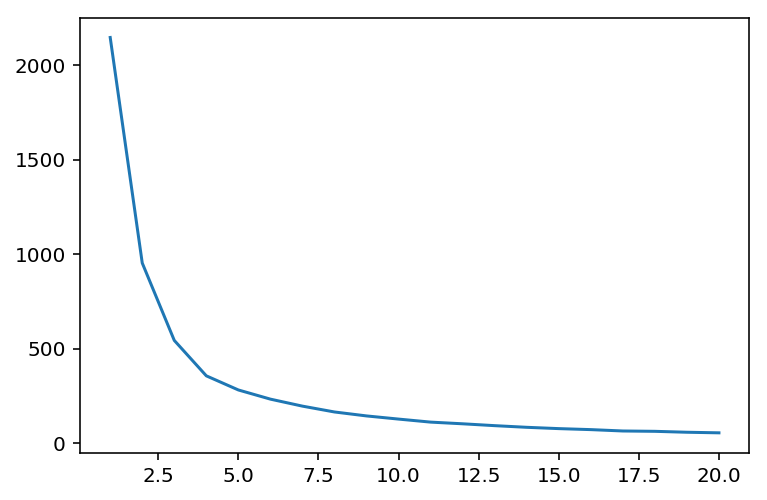

In [16]:
plt.plot(ks, k_inertia)

In [17]:
diff = np.diff(k_inertia)

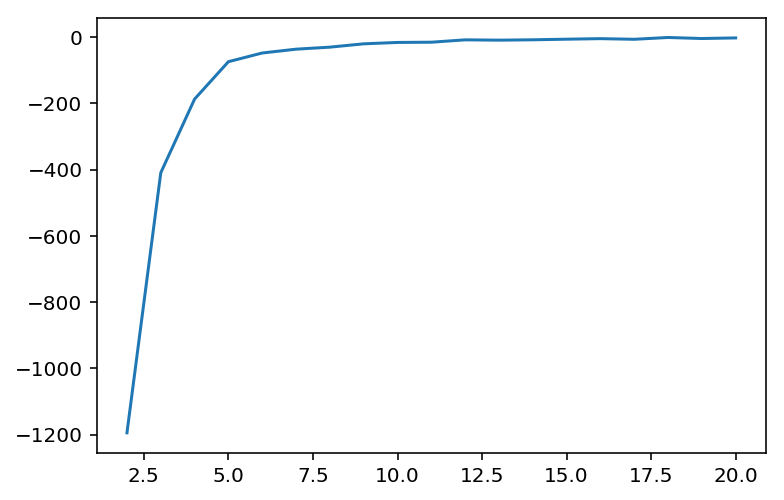

In [18]:
plt.plot(ks[1:], diff)

In [19]:
diff_r = diff[1:] / diff[:-1]

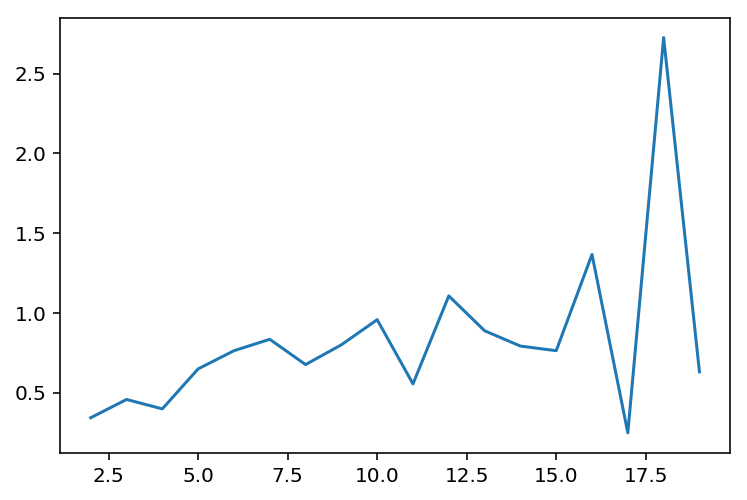

In [20]:
plt.plot(ks[1:-1], diff_r)

In [21]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

17

Значение 2 отбросим (не понял, как это сделать программно - всегда наилучее разбиение получалось при 2 кластерах. Возьмем по графику количество кластеров = 13

In [22]:
clusters = KMeans(n_clusters=13).fit_predict(coords)

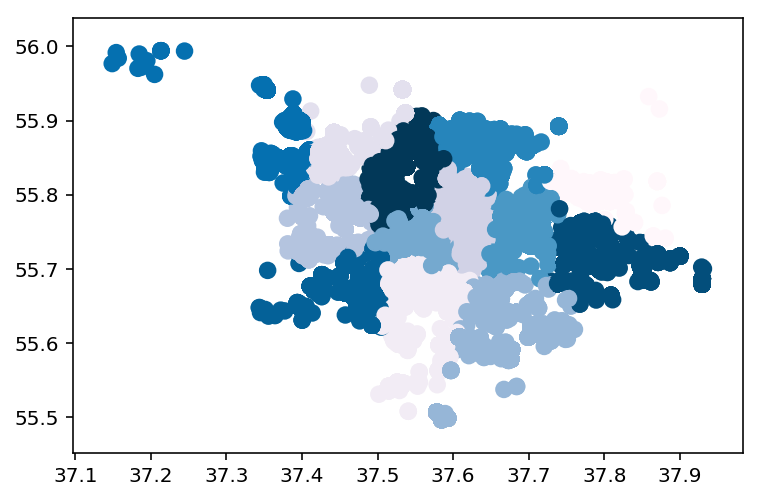

In [23]:
plt.scatter(coords.x, coords.y, c=clusters, cmap='PuBu_r', s=60)

Выделим голосовавших "за" и "против"

In [24]:
X_neg = geo[geo['comment_class']==-1]
X_pos = geo[geo['comment_class']==1]

In [25]:
X_pos = X_pos[['x', 'y']]
X_neg = X_neg[['x','y']]

Построим карты разбиений: всех голосовавших, только "за" и только "против".

In [26]:
data = [coords, X_pos, X_neg]

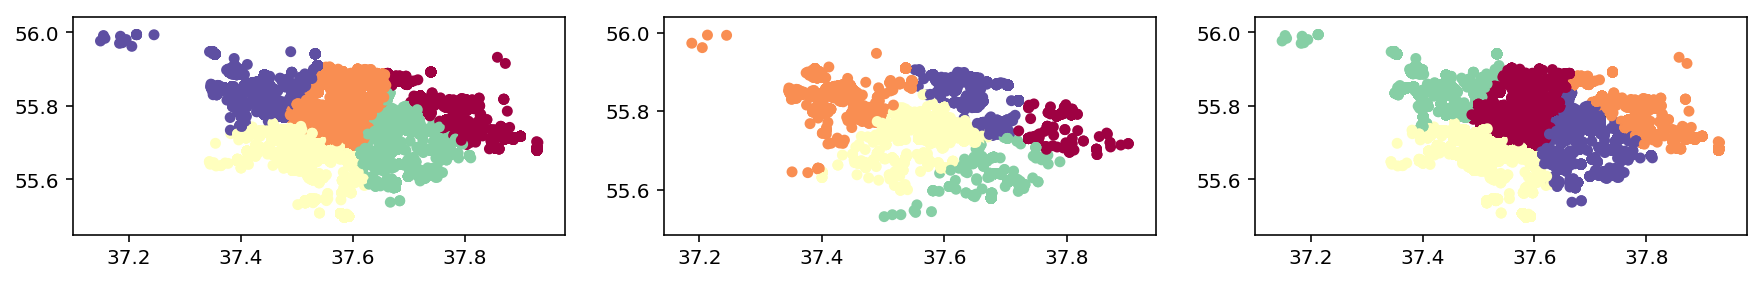

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
for ax, df in zip(axes, data):
    clusters = KMeans(n_clusters=5).fit_predict(df)
    ax.scatter(df.x, df.y, c=clusters, cmap='Spectral', s=20)

Разумеется, можно для каждого набора данных проводить анализ опитмального количества кластеров, но я этого не делал, так как не совсем понял в принципе смысл результатов этой разбивки...

Попытался попробовать DBSCAN, но уж очень жадный до памяти алгоритм. С epsilon более 0.01 на моем компе не хватает памяти. Поэтому поиграться не удалось, только в таком виде.
Люди писали, что есть более оптимальная реализация в ELKI, но я не смог скомпилировать/установить.

In [28]:
from sklearn.cluster import DBSCAN

In [29]:
DB_class = DBSCAN(eps = 0.01).fit_predict(coords)

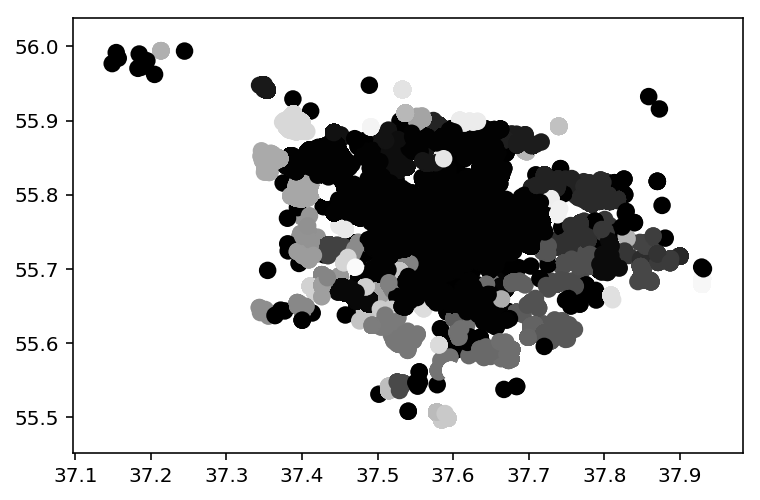

In [30]:
plt.scatter(coords.x, coords.y, c=DB_class, cmap='gray', s=60)

In [31]:
plt.colormaps()

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Vega10',
 'Vega10_r',
 'Vega20',
 'Vega20_r',
 'Vega20b',
 'Vega20b_r',
 'Vega20c',
 'Vega20c_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone